# Project 3: Filtering vs wrapping
**Updated:** 2019-06-05  
**Author:** Anna Carlsson

### Packages

In [1]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
import os

from skfeature.function.similarity_based.fisher_score import fisher_score, feature_ranking
from sklearn.model_selection import train_test_split  
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from ReliefF import ReliefF
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

%matplotlib inline
plt.style.use('ggplot')

### Load dataset(s)
All datasets were generated in R using the function genRandomCluster() in the package clusterGeneration.

In [2]:
os.chdir("/Users/anna/Dokument/GitHub/MVE440/Exam/Datasets/")
data = pd.read_csv("20000obs_100feat_noisy.csv")
labels = data[data.columns[0]]
data = data.drop('label', axis = 1)
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100
0,1.958330,19.861963,-6.012015,19.545288,-14.682637,-5.880105,-6.898129,16.752986,-14.383706,42.202332,...,3.038125,-29.542047,-30.959290,44.791772,-7.089193,5.701090,15.747128,-17.684196,16.927795,11.423424
1,-3.457390,31.205427,-10.931165,1.319106,-20.803353,4.418279,-21.575963,49.185921,-22.113289,19.895249,...,-11.970413,-20.636950,19.861366,28.172920,-1.082681,-11.924020,16.827338,14.774585,15.523261,33.014669
2,27.574626,19.784593,3.084046,-6.864265,-0.997711,-14.051904,-5.732749,-9.403862,-2.606395,22.301271,...,10.075759,-3.459870,19.426946,1.093319,-1.228763,-2.358579,17.649700,7.498269,-24.041699,44.477716
3,7.038652,-9.700411,-4.069405,34.639339,-4.184004,-14.698963,3.177526,-2.885391,26.549426,-14.048913,...,24.870223,3.361145,-13.255085,-27.668114,-21.571352,21.059454,-16.297750,31.643648,19.681068,-18.825292
4,-15.362667,8.905572,20.116357,11.828916,24.353882,18.564939,11.151352,26.017453,-24.944461,-68.034564,...,48.565089,-1.275817,8.092226,1.931095,-33.348455,17.362939,10.650260,16.064802,11.121783,-11.507149


### Split data intro training
Throughout this project, we use logistic regression since the goal is binary classification.

In [3]:
train_features, test_features, train_labels, test_labels = train_test_split(  
    data,
    labels,
    test_size=0.2)

## Filtering methods

### F-score

In [4]:
# Simple implementation of F-score. Based on function fscore from the PredPsych package in R by Atesh Koul
# and the definition of F-score given in the paper: "Combining SVMs with Various Feature Selection Strategies#
# by Yi-Wei Chen and Chih-Jen Lin

def fscore(data,labels):
    classes = np.unique(labels)
    pos_set = data[labels==classes[0],]
    neg_set = data[labels==classes[1],]
    
    nbr_features = data.shape[1]
    fscore = np.arange(nbr_features, dtype=float)

    for i in range(0,nbr_features):
        fscore[i] = ((np.mean(pos_set[:,i])-np.mean(data[:,i]))**2  +  (np.mean(neg_set[:,i])-np.mean(data[:,i]))**2)/(np.var(pos_set[:,i],ddof=1)) + np.var(neg_set[:,i],ddof=1)
    
    return fscore

Runtime for f-score: 43.26071381568909


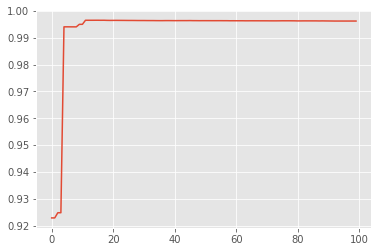

In [5]:
data_np = data.to_numpy()
labels_np = labels.to_numpy()

start = time.time()
score = fscore(data_np,labels_np)
rank = np.argsort(score)

N = rank.shape[0]
fscore_auc = np.arange(N, dtype=float)

for n in range(N):
    num_features = n + 1
    features_temp = train_features.columns[rank[0:num_features]]
    model = LogisticRegression(solver='liblinear')
    model.fit(train_features[features_temp], train_labels)
    pred_temp = model.predict_proba(test_features[features_temp]) 
    auc_temp = roc_auc_score(test_labels, pred_temp[:,1])
    fscore_auc[n] = auc_temp
    
stop = time.time()
runtime = stop - start
print('Runtime for f-score: {}'.format(runtime))

plt.plot(range(N),fscore_auc);

### Relief

Runtime for relief: 6879.771046876907


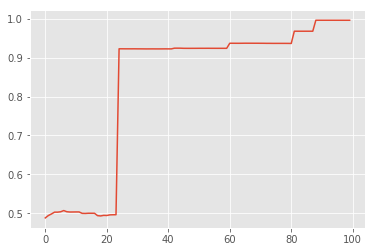

In [6]:
train_features_np = train_features.to_numpy()
train_labels_np = train_labels.to_numpy()
test_features_np = test_features.to_numpy()
test_labels_np = test_labels.to_numpy()

start = time.time()

relief_auc = np.arange(N, dtype=float)
for n in range(N):
    num_features = n + 1
    fs = ReliefF(n_neighbors = 5, n_features_to_keep = num_features)
    features_temp = fs.fit_transform(train_features_np, train_labels_np)
    test_temp = fs.transform(test_features_np)
    model = LogisticRegression(solver='liblinear')
    model.fit(features_temp, train_labels_np)
    pred_temp = model.predict_proba(test_temp) 
    auc_temp = roc_auc_score(test_labels, pred_temp[:,1])
    relief_auc[n] = auc_temp
    
stop = time.time() 
runtime = stop - start
print('Runtime for relief: {}'.format(runtime))

plt.plot(range(N),relief_auc);

### Random forests (variable importance)

Runtime for random forests: 106.8667140007019


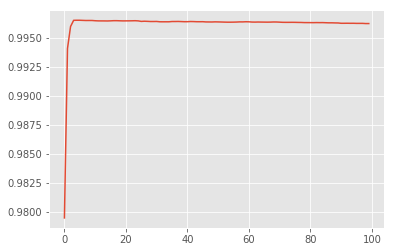

In [7]:
start = time.time()

rf = RandomForestClassifier(n_estimators=300) 
rf.fit(train_features, train_labels) 
importances = rf.feature_importances_
feature_importances = np.argsort(importances)[::-1]

rf_auc = np.arange(N, dtype=float)
for n in range(N):
    num_features = n + 1
    features_temp = train_features.columns[feature_importances[0:num_features]]
    model = LogisticRegression(solver='liblinear')
    model.fit(train_features[features_temp], train_labels)
    pred_temp = model.predict_proba(test_features[features_temp]) 
    auc_temp = roc_auc_score(test_labels, pred_temp[:,1])
    rf_auc[n] = auc_temp
    
stop = time.time() 
runtime = stop - start
print('Runtime for random forests: {}'.format(runtime))

plt.plot(range(N),rf_auc);

## Wrapping methods

### Forward selection

Runtime for forward selection: 6911.61147403717


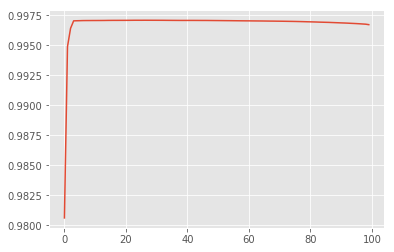

In [8]:
data_np = data.to_numpy()
labels_np = labels.to_numpy()

start = time.time()

fs = SFS(LogisticRegression(solver='liblinear'),  
               k_features=N,
               forward=True,
               verbose=0,
               scoring='roc_auc',
               cv=5)

sel_features = fs.fit(data_np, labels_np) 
filtered_features = data.columns[list(sel_features.k_feature_idx_)]  
    
end = time.time()
runtime = end - start
print('Runtime for forward selection: {}'.format(runtime))

# Save AUC scores to array
metric = fs.get_metric_dict()
orderedNames = list(metric.keys())
forward_auc = np.array([list(metric[i]['avg_score'] for i in orderedNames)])
forward_auc = forward_auc.T

plt.plot(range(N),forward_auc);

### Backward selection

Runtime for backward selection: 12130.293635129929


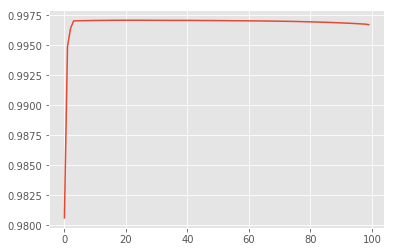

In [9]:
start = time.time()

fs = SFS(LogisticRegression(solver='liblinear'),  
               k_features=1,
               forward=False,
               verbose=0,
               scoring='roc_auc',
               cv=5)

sel_features = fs.fit(data_np, labels_np) 
filtered_features = data.columns[list(sel_features.k_feature_idx_)]  
    
end = time.time()
runtime = end - start
print('Runtime for backward selection: {}'.format(runtime))

# Save AUC scores to array
metric = fs.get_metric_dict()
orderedNames = list(metric.keys())
backward_auc = np.array([list(metric[i]['avg_score'] for i in orderedNames)])
backward_auc = np.flip(backward_auc).T

plt.plot(range(N),backward_auc);

## Create plots
Plot all AUC scores from the methods in same figure.

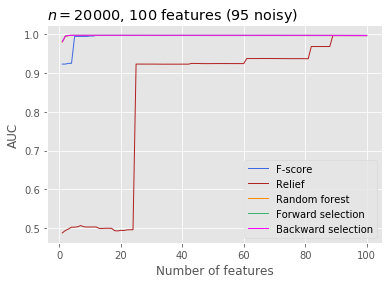

In [10]:
lw = 1

plt.figure(figsize=(6,4))
plt.plot(range(1,N+1),fscore_auc, label='F-score', color='royalblue', linewidth=lw)
plt.plot(range(1,N+1),relief_auc, label='Relief', color='firebrick', linewidth=lw)
plt.plot(range(1,N+1),rf_auc,label='Random forest', color='darkorange', linewidth=lw)
plt.plot(range(1,N+1),forward_auc,label='Forward selection', color='mediumseagreen', linewidth=lw)
plt.plot(range(1,N+1),backward_auc,label='Backward selection', color='fuchsia',linewidth=lw)
plt.title(r'$n=20000$, $100$ features (95 noisy)',loc='left')
plt.xlabel('Number of features')
plt.ylabel('AUC')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('20000obs_100fts_noisy.pdf') 
plt.show()

## Running times
In this section, I just save some running times for the algorithms which are compared in a plot.

In [29]:
# The order: f-score, relief, rf, forward, backward

rt_1000_35 = np.array([0.4492309093475342,5.894724130630493,0.9542200565338135,17.20533800125122,27.782393217086792])
rt_1000_35_noisy = np.array([0.3361070156097412,4.93890380859375,1.1867740154266357,18.448683977127075,31.040831089019775])
rt_1000_100 = np.array([2.0144782066345215,24.80722713470459,3.0276148319244385,353.34461998939514,469.8920269012451])
rt_1000_100_noisy = np.array([3.1143369674682617,25.244606018066406,3.4624791145324707,417.9607148170471,595.8921358585358])
rt_20000_35 = np.array([5.681956052780151,1402.5066120624542,24.322164058685303,214.82762694358826,370.03309416770935])
rt_20000_35_noisy = np.array([4.854088068008423,1303.2406568527222,27.17551326751709,279.5673921108246,474.82668924331665])
rt_20000_100 = np.array([24.5237979888916,7753.162488698959,153.5235059261322,4616.0688490867615,8352.480587005615])
rt_20000_100_noisy = np.array([43.26071381568909,6879.771046876907,106.8667140007019,6911.61147403717,12130.293635129929])

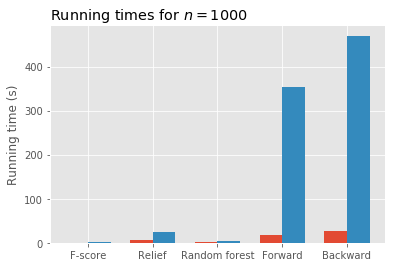

In [33]:
# Plot figure for n=1000 datasets
names = ('F-score','Relief','Random forest','Forward', 'Backward')

n_groups = 5
index = np.arange(n_groups)
bar_width = 0.35
plt.figure(figsize=(6,4))
plt.bar(index,rt_1000_35,0.35);
plt.bar(index+bar_width,rt_1000_100,0.35);
plt.xticks(index + bar_width/2, ('F-score','Relief','Random forest','Forward', 'Backward'));
plt.title('Running times for $n=1000$',loc='left');
plt.ylabel('Running time (s)');
plt.savefig('running_times_1000obs.pdf') 

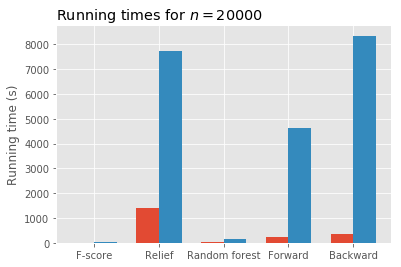

In [34]:
# Plot figure for n=20000 datasets
names = ('F-score','Relief','Random forest','Forward', 'Backward')

n_groups = 5
index = np.arange(n_groups)
bar_width = 0.35
plt.figure(figsize=(6,4));
plt.bar(index,rt_20000_35,0.35);
plt.bar(index+bar_width,rt_20000_100,0.35);
plt.xticks(index + bar_width/2, ('F-score','Relief','Random forest','Forward', 'Backward'));
plt.title('Running times for $n=20000$',loc='left');
plt.ylabel('Running time (s)');
plt.savefig('running_times_20000obs.pdf') 